In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re

In [2]:
def read_csv(path: str):
    """
    Funcao responsavel por realizar a leitura de um dataset em formato csv

    Parameters:
    path: Arquivo csv contendo os dados

    Returns: 
    df: DataFrame contendo os dados já lidos 
    """
    df = pd.read_csv(path, low_memory=True, dtype=str)
    if "votos_cantidad" in df.columns:
        df["votos_cantidad"] = df["votos_cantidad"].astype("int32")

    return df

In [44]:
def normalize_name(name: str)->str:
    if pd.isna(name):  # trata valores nulos
        return name
    
    # 1. Remove acentos
    name = unicodedata.normalize('NFD', name)
    name = ''.join(c for c in name if unicodedata.category(c) != 'Mn')

    # 2. Coloca em maiúsculas
    name = name.upper().strip()

    # 3. Padronizações específicas
    if "JUNTOS POR EL CAMBIO" in name:
        return "JUNTOS POR EL CAMBIO"
    elif "HACEMOS" in name:
        return "HACEMOS"
    elif "FRENTE DE IZQUIERDA" in name:
        return "FRENTE DE IZQUIERDA Y DE TRABAJADORES"
    elif "FRENTE DE TODOS" in name:
        return "FRENTE DE TODOS"
    elif "ARI" in name:
        return "COALICION CIVICA - AFIRMACION PARA UNA REPUBLICA IGUALITARIA (ARI)"
    
    # 4. Limpeza final
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

In [4]:
def plot_votos(df: pd.DataFrame, cargo:str):
    """
    Plota um gráfico de barras com os votos agrupados por partido para um determinado cargo.

    Parameters:
    df: DataFrame contendo os dados
    cargo: Cargo a ser utilizado como filtro (string)
    """

    # Filtrando para apenas Presidente
    df_presidente = df[df["cargo_nombre"] == cargo]

    # Agrupando votos para Presidente por Partido
    votos_por_partido = (df_presidente.groupby("agrupacion_nombre")["votos_cantidad"].sum().sort_values(ascending=False))

    # Exibição do gráfico
    plt.figure(figsize=(10,6))
    votos_por_partido.plot(kind="bar")
    plt.title(f"Votos para {cargo} por Partido")
    plt.ylabel("Quantidade de votos")
    plt.xlabel("Partido", fontsize=8)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
#Leitura do CSV de 2023 contendo os resultados eleitorais provisorios
df_2023 = read_csv("data/ResultadoElectorales_2023_Generales.csv")
df_2023["agrupacion_nombre"] = df_2023["agrupacion_nombre"].apply(normalize_name)

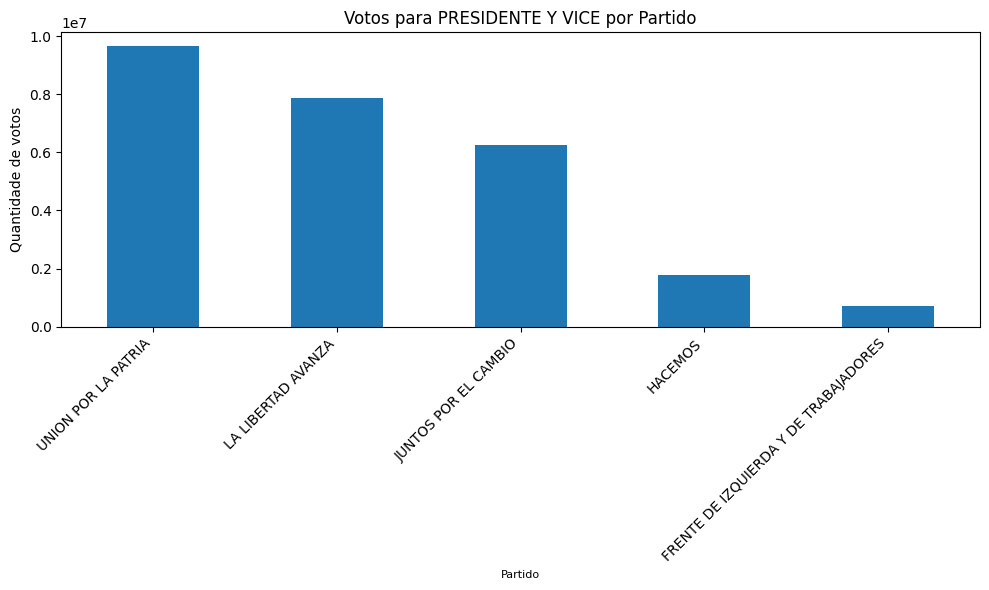

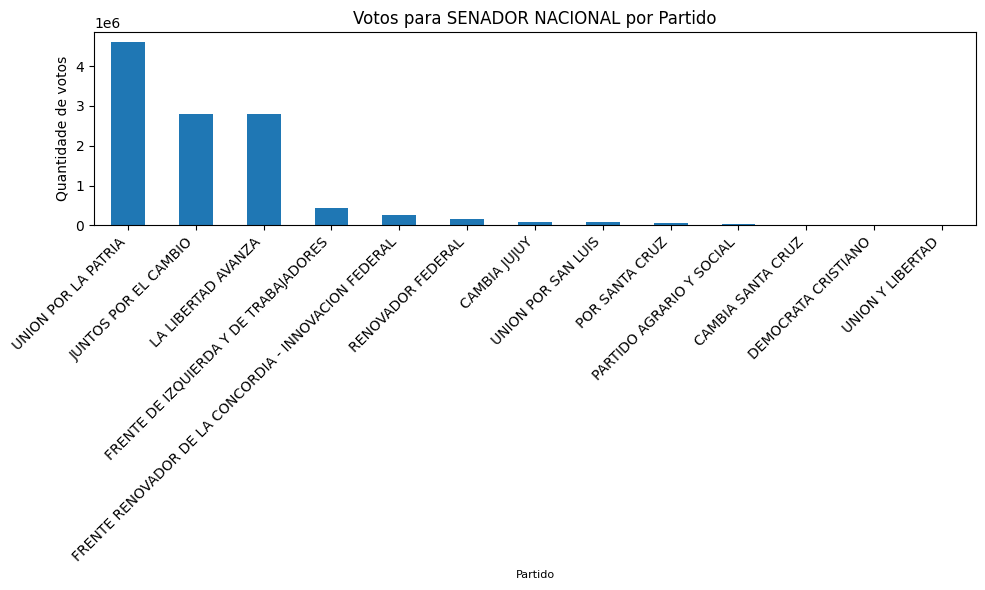

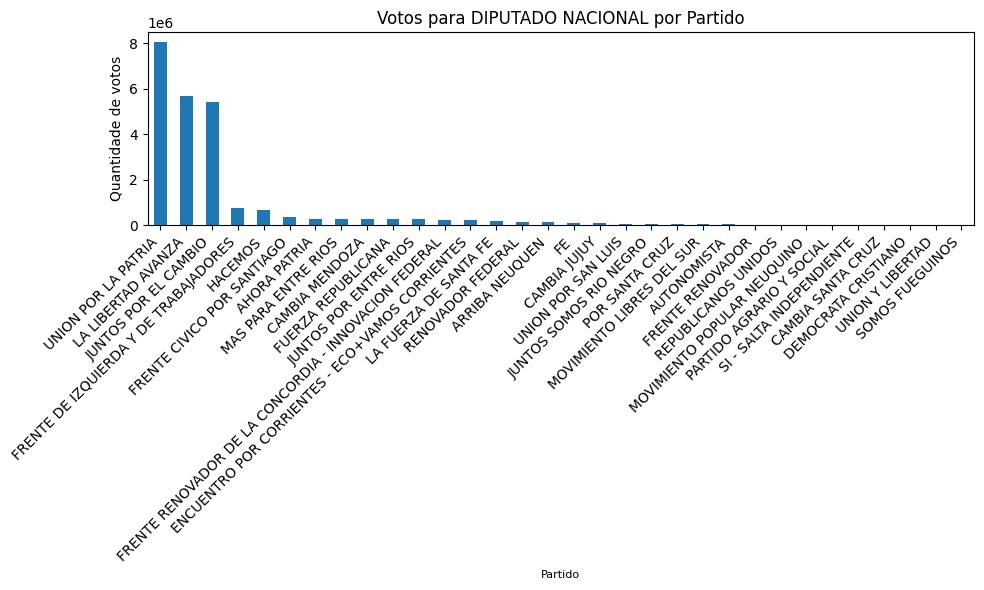

In [6]:
plot_votos(df_2023,"PRESIDENTE Y VICE")
plot_votos(df_2023,"SENADOR NACIONAL")
plot_votos(df_2023,"DIPUTADO NACIONAL")

In [7]:
#Leitura do CSV de 2021 contendo os resultados eleitorais provisorios
df_2021 = read_csv("data\ResultadosElectorales_2021_Generales.csv")
df_2021["agrupacion_nombre"] = df_2021["agrupacion_nombre"].apply(normalize_name)

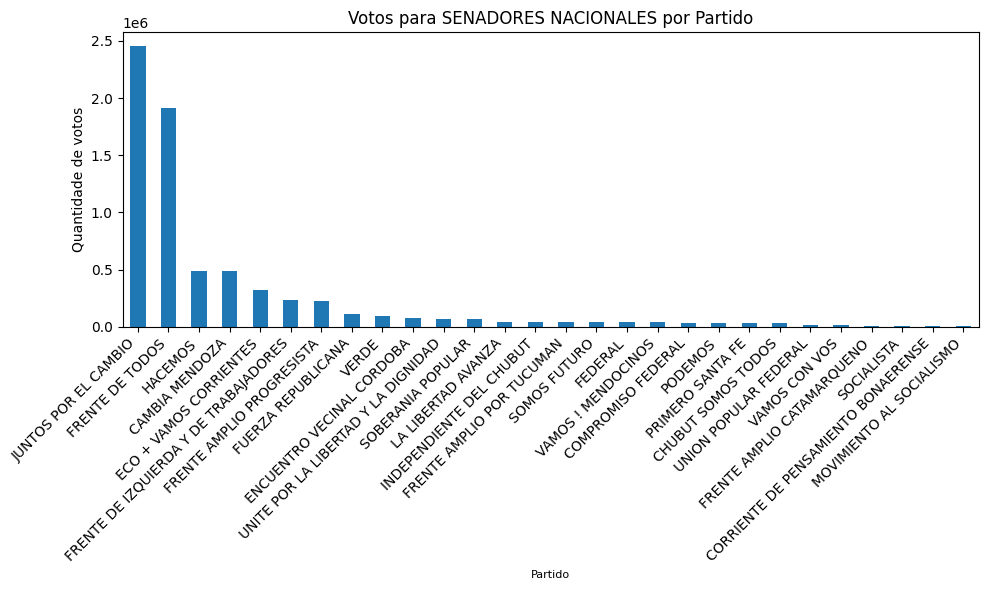

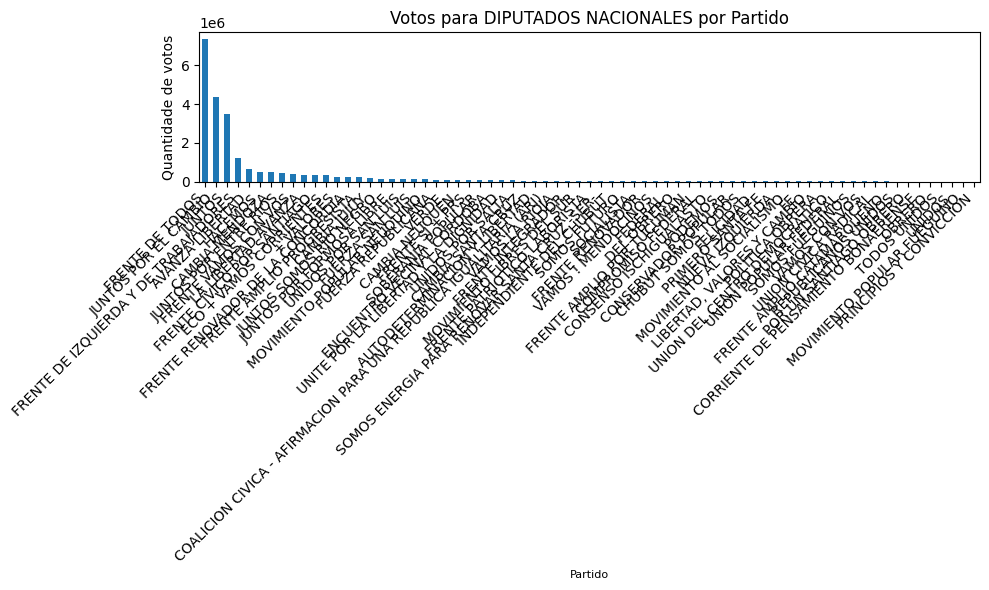

In [8]:
plot_votos(df_2021,"SENADORES NACIONALES")
plot_votos(df_2021,"DIPUTADOS NACIONALES")

In [9]:
#Leitura do CSV de 2019 contendo os resultados eleitorais provisorios
df_2019 = read_csv("data\ResultadosElectorales_2019_Generales.csv")
df_2019['agrupacion_nombre'] = df_2019['agrupacion_nombre'].apply(normalize_name)

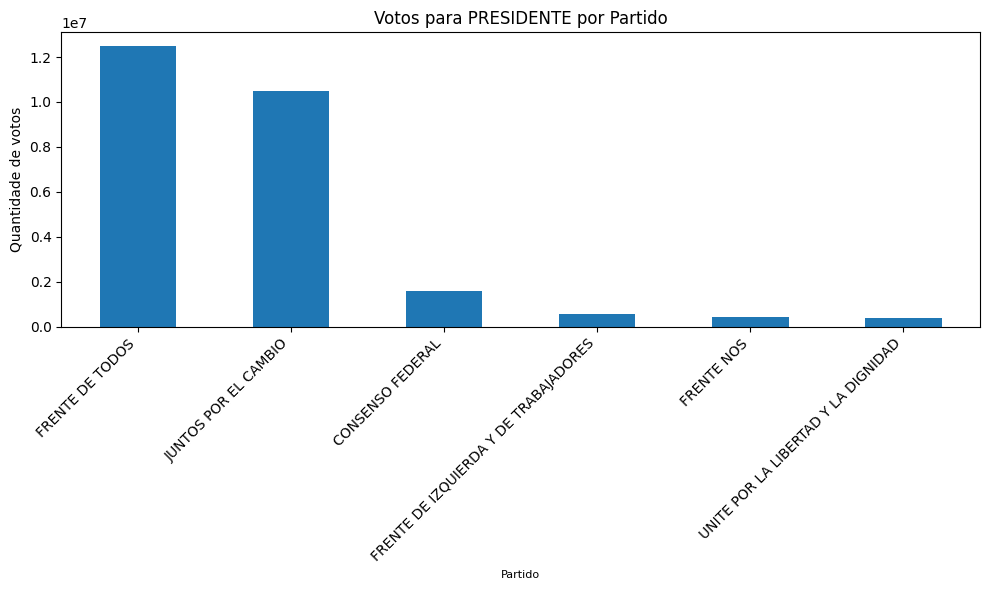

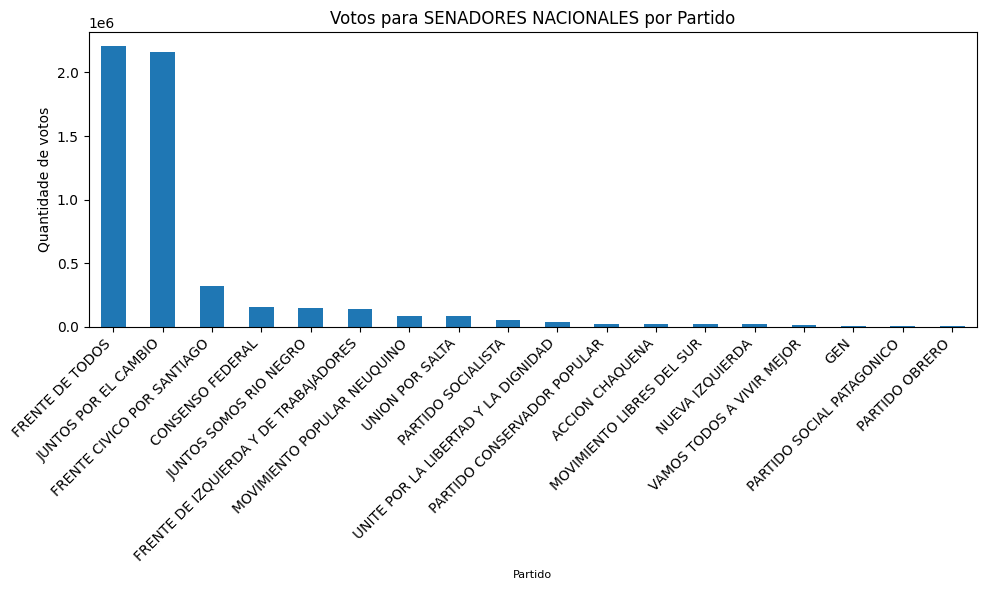

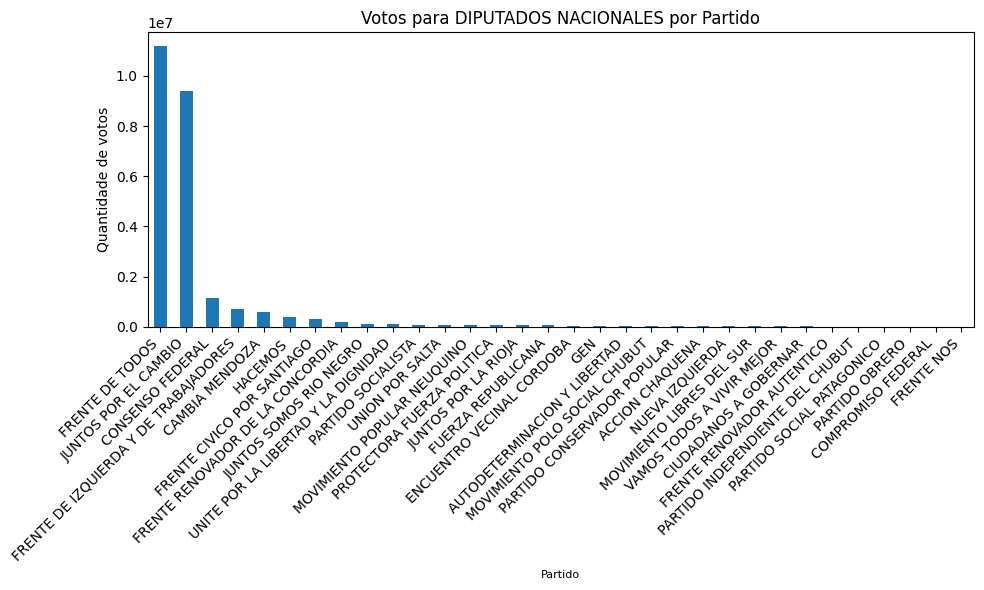

In [10]:
plot_votos(df_2019,"PRESIDENTE")
plot_votos(df_2019,"SENADORES NACIONALES")
plot_votos(df_2019,"DIPUTADOS NACIONALES")

In [11]:
#Leitura do CSV de 2015 contendo os resultados eleitorais provisorios
df_2015 = read_csv("data\ResultadosElectorales2015.csv")
df_2015['agrupacion_nombre'] = df_2015['agrupacion_nombre'].apply(normalize_name)

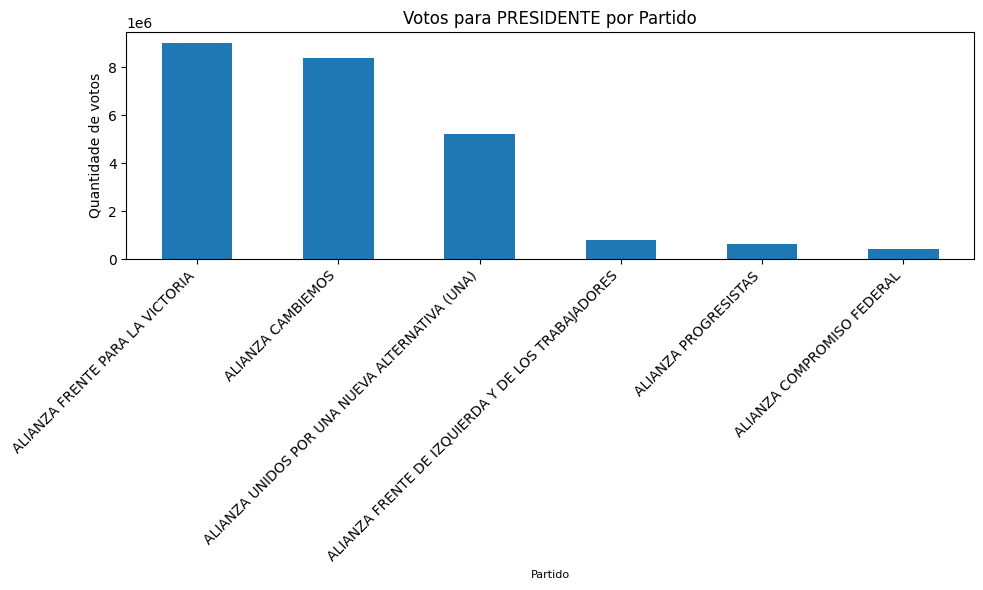

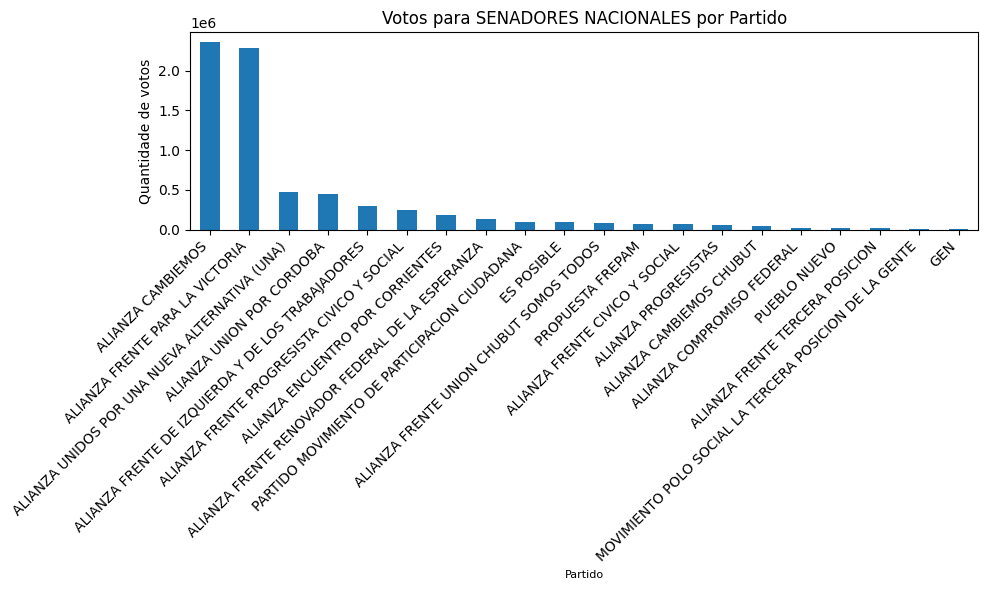

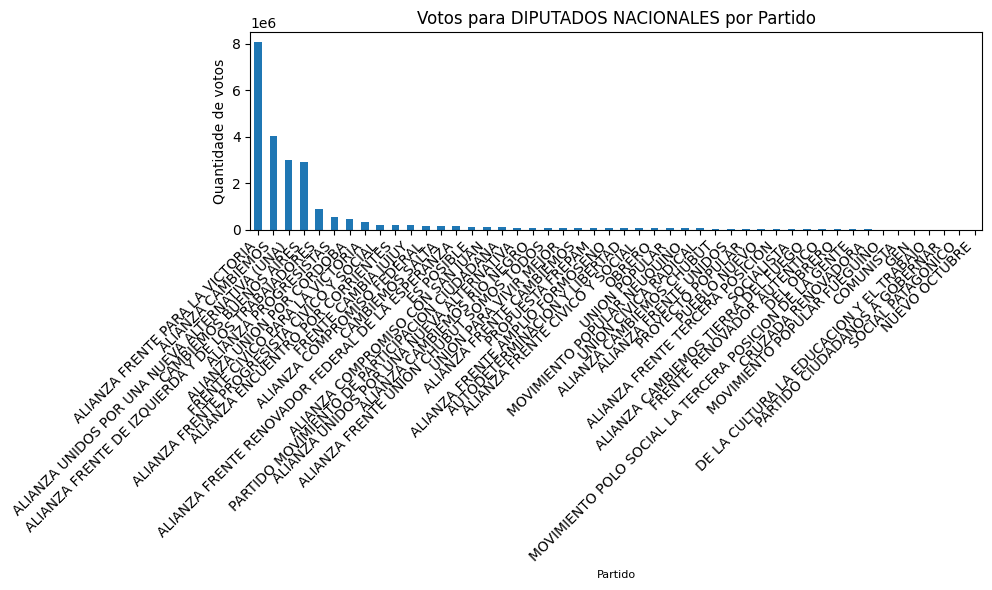

In [12]:
plot_votos(df_2015,"PRESIDENTE")
plot_votos(df_2015,"SENADORES NACIONALES")
plot_votos(df_2015,"DIPUTADOS NACIONALES")

In [45]:
#Leitura do CSV de 2013 contendo os resultados eleitorais provisorios
df_2013 = read_csv("data\ResultadosElectorales2013.csv")
df_2013['agrupacion_nombre'] = df_2013['agrupacion_nombre'].apply(normalize_name)

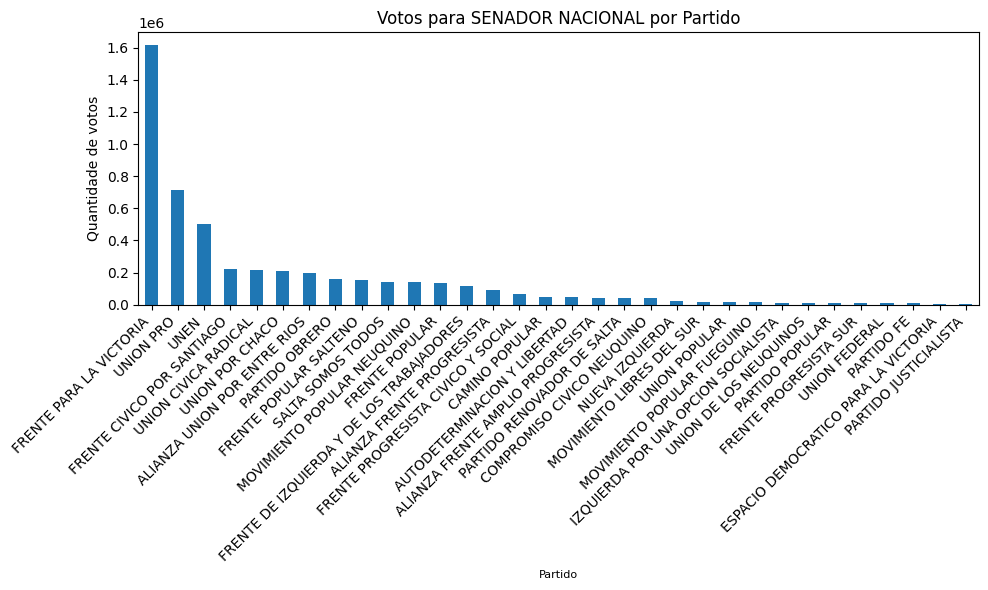

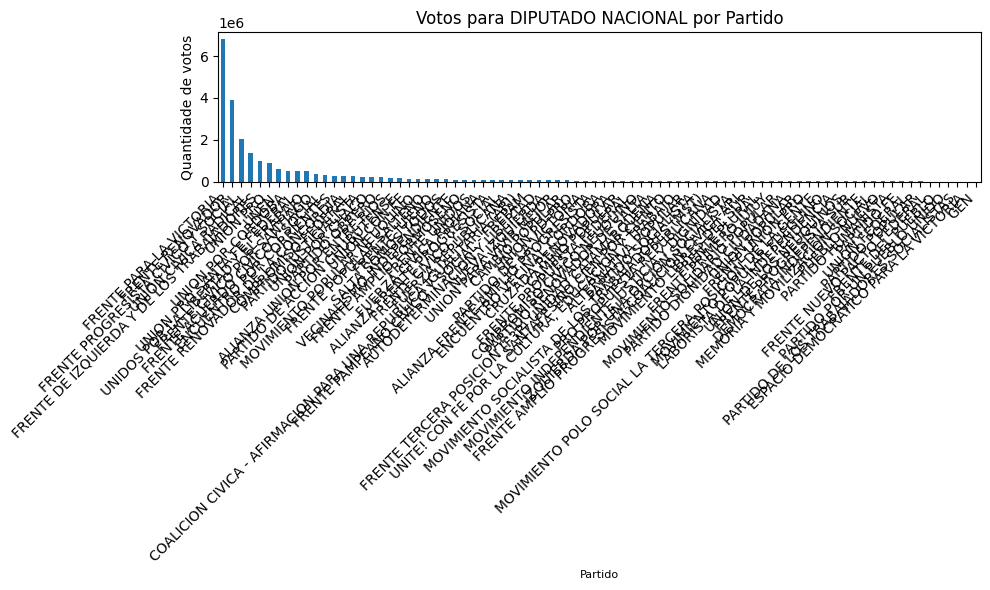

In [14]:
plot_votos(df_2013,"SENADOR NACIONAL")
plot_votos(df_2013,"DIPUTADO NACIONAL")

In [46]:
df_ipp = read_csv("data\PartidosNacionaisArgentinaIPP.csv")
df_ipp['Partidos/Coalizacoes Nacionais'] = df_ipp['Partidos/Coalizacoes Nacionais'].apply(normalize_name)

In [47]:
def calcular_ipp_eleicao(df_votos: pd.DataFrame, df_ipp: pd.DataFrame, filtro_cargo: str ,coluna_partido="agrupacion_nombre"):
    # Filtra apenas a eleicao e o cargo desejado
    df_cargo = df_votos[df_votos["cargo_nombre"] == filtro_cargo].copy()

    # Merge para associar o IPP de cada partido
    df_merge = df_cargo.merge(df_ipp, left_on=coluna_partido, right_on="Partidos/Coalizacoes Nacionais", how='left')

    # Renomeia a col IPP
    df_merge.rename(columns={"IPP (Índice de Posição Política)": "IPP"}, inplace=True)

    # Converte para numérico 
    df_merge["IPP"] = pd.to_numeric(df_merge["IPP"], errors="coerce")
    df_merge["votos_cantidad"] = pd.to_numeric(df_merge["votos_cantidad"], errors="coerce")
    
    # Calcula peso IPP * votos
    df_merge["IPP_ponderado"] = df_merge["IPP"] * df_merge["votos_cantidad"]

    # Soma todos os IPPs ponderados
    ipp_total = df_merge["IPP_ponderado"].sum()

    return ipp_total, df_merge

In [48]:
anos_dfs_cargo = {
    2023: (df_2023, "DIPUTADO NACIONAL"),
    2021: (df_2021, "DIPUTADOS NACIONALES"),
    2019: (df_2019, "DIPUTADOS NACIONALES"),
    2015: (df_2015, "DIPUTADOS NACIONALES"),
    2013: (df_2013, "DIPUTADO NACIONAL"),
}

resultados = {}

for ano, (df, cargo) in anos_dfs_cargo.items():
    ipp_total, df_merge = calcular_ipp_eleicao(df, df_ipp, cargo)
    resultados[ano] = (ipp_total, df_merge)
    print(f"IPP total da eleição {ano}: {ipp_total}")

IPP total da eleição 2023: 8061600.0
IPP total da eleição 2021: -2555370.0
IPP total da eleição 2019: -2336325.0
IPP total da eleição 2015: 0.0
IPP total da eleição 2013: -14072374.0


In [49]:
partidos_ja_classificados = set(df_ipp["Partidos/Coalizacoes Nacionais"].dropna().unique())

for ano, (_, df_merge) in resultados.items():
    partidos_ano = set(df_merge["agrupacion_nombre"].dropna().unique())
    partidos_nao_classificados = partidos_ano - partidos_ja_classificados

    print(f"Partidos de {ano} para deputados nacionais ainda nao classificados:")
    print(partidos_nao_classificados)
    print(len(partidos_nao_classificados))
    print()

Partidos de 2023 para deputados nacionais ainda nao classificados:
{'JUNTOS POR ENTRE RIOS', 'PARTIDO AGRARIO Y SOCIAL', 'AUTONOMISTA', 'FE', 'DEMOCRATA CRISTIANO', 'REPUBLICANOS UNIDOS', 'MAS PARA ENTRE RIOS', 'MOVIMIENTO POPULAR NEUQUINO', 'UNION POR SAN LUIS', 'FUERZA REPUBLICANA', 'FRENTE RENOVADOR DE LA CONCORDIA - INNOVACION FEDERAL', 'FRENTE CIVICO POR SANTIAGO', 'RENOVADOR FEDERAL', 'AHORA PATRIA', 'ENCUENTRO POR CORRIENTES - ECO+VAMOS CORRIENTES', 'SOMOS FUEGUINOS', 'ARRIBA NEUQUEN', 'JUNTOS SOMOS RIO NEGRO', 'POR SANTA CRUZ', 'SI - SALTA INDEPENDIENTE', 'CAMBIA SANTA CRUZ', 'LA FUERZA DE SANTA FE', 'CAMBIA JUJUY', 'UNION Y LIBERTAD'}
24

Partidos de 2021 para deputados nacionais ainda nao classificados:
{'JUNTOS POR ENTRE RIOS', 'CONSENSO ISCHIGUALASTO', 'SOMOS ENERGIA PARA RENOVAR SANTA CRUZ -SER-', 'DEL OBRERO', 'CAMBIA NEUQUEN', 'UNIDOS', 'FRENTE VAMOS CON VOS', 'PODEMOS', 'SOBERANIA POPULAR', 'AUTODETERMINACION Y LIBERTAD', 'FE', 'SOCIALISTA', 'VAMOS LA RIOJA', 'REPUBLICA

In [50]:
coalizoes = [
    "JUNTOS POR EL CAMBIO",
    "UNION POR LA PATRIA", 
    "LA LIBERTAD AVANZA",
    "FRENTE DE IZQUIERDA Y DE TRABAJADORES",
    "HACEMOS",
    "FRENTE DE TODOS",
    "CONSENSO FEDERAL",
    "TERCERA VIA",
    "CAMBIA MENDOZA",
    "CAMBIEMOS",
    "UNIDAD CIUDADANA",
    "JUSTICIALISMO",
    "1PAIS",
    "PARTIDO SOCIALISTA",
    "FRENTE PARA LA VICTORIA",
    "UNIDOS POR UNA NUEVA ALTERNATIVA",
    "PROGRESISTAS",
    "COMPROMISSO FEDERAL",
    "FRENTE DE RENOVACION",
    "PERONISMO FEDERAL",
    "UNION PRO",
    "MOVIMIENTO SOCIALISTA DE LOS TRABAJADORES",
    "FRENTE PROGRESISTA CIVICO Y SOCIAL",
    "FRENTE RENOVADOR",
    "PROPUESTA REPUBLICANA",
    "PARTIDO FE",
    "NUEVA IZQUIERDA",
    ""
]

In [51]:
def calcular_votos_em_coalizoes(df, coalizoes, ano):
    # Cria coluna indicando se o partido pertence à coalizão
    df['eh_coalizao'] = df['agrupacion_nombre'].isin(coalizoes)

    # Calcula os votos
    votos_coalizao = df.loc[df['eh_coalizao'], 'votos_cantidad'].sum()
    votos_outros = df.loc[~df['eh_coalizao'], 'votos_cantidad'].sum()

    # Exibe o resultado
    print(f"Resultados de {ano}:")
    print(f"Votos em coalizões: {votos_coalizao:,}")
    print(f"Votos fora de coalizões: {votos_outros:,}\n")

    return votos_coalizao, votos_outros

for ano, (_, df_merge) in resultados.items():
    calcular_votos_em_coalizoes(df_merge, coalizoes, ano)

Resultados de 2023:
Votos em coalizões: 21,684,410
Votos fora de coalizões: 5,856,856

Resultados de 2021:
Votos em coalizões: 14,867,604
Votos fora de coalizões: 10,255,573

Resultados de 2019:
Votos em coalizões: 23,953,523
Votos fora de coalizões: 2,969,739

Resultados de 2015:
Votos em coalizões: 0
Votos fora de coalizões: 24,961,718

Resultados de 2013:
Votos em coalizões: 18,749,360
Votos fora de coalizões: 10,045,876

